In [1]:
import os, json
import pandas as pd
import json 
import plotly.express as px
from IPython.display import Image
from unidecode import unidecode

from pandarallel import pandarallel
pandarallel.initialize(nb_workers = 10, progress_bar=True)

import regex as re
re.DEFAULT_VERSION = re.VERSION1

import gc
import string
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.models.callbacks import CallbackAny2Vec
from polyleven import levenshtein
import spacy
import numpy as np
import pickle

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import AutoTokenizer
import umap

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


2023-01-23 17:08:31.703060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 17:08:33.335939: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-23 17:08:33.336100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-23 17:08:33.336112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# WSD Using Word2Vec 

In [140]:
textDf = pd.read_csv('data/le_figaro.csv')

## Training model

In [2]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss if (self.epoch == 0) else loss-self.loss_previous_step)
        print('Loss after epoch {}: {}'.format(self.epoch, self.losses[-1]))
        self.epoch += 1
        self.loss_previous_step = loss

In [8]:
# set space between word and punctuation, remove dash and unwanted apostrophe
applyRegexSub =  lambda  pattern, rep : lambda text : re.compile(pattern).sub(rep, text)

textDf['raw_article'] = textDf.content.apply(applyRegexSub('(?<=(?:\W|^))\'(?=(:?\w|$))',''))
textDf['raw_article'] = textDf.raw_article.str.replace('-',' ')
textDf['raw_article'] = textDf.raw_article.apply(applyRegexSub('(?<=\w)\'(?=(?:\w|$))','\' '))

textDf['raw_article'] = textDf.raw_article.apply(applyRegexSub('(?<=\w)(?=[\!,\.:;\?](?:\W|$))',' '))
textDf['raw_article'] = textDf.raw_article.apply(applyRegexSub('(?<=(?:\W|^)[\!,\.:;\?])(?=(:?\w|$))',' '))

# uniformize digits
textDf['raw_article'] = (' '+textDf.raw_article+' ').str.replace('\d','$',regex=True)
textDf = textDf[textDf['raw_article'].apply(len)>50].copy()
print('cleaning done')
                                                 
raw_articles = textDf['raw_article'].str.split().tolist()
bigram = Phrases(raw_articles, min_count=15, threshold=15)
bigram_mod = Phraser(bigram)
raw_articles = list(bigram_mod[raw_articles])
trigram = Phrases(raw_articles, min_count=10, threshold=15)
trigram_mod = Phraser(bigram)
raw_articles = list(trigram_mod[raw_articles])
textDf["nGram"] = raw_articles
textDf["nGram"] = textDf["nGram"].apply(' '.join)
textDf.to_csv('data/le_figaro_word2vec.csv',index=False)

In [3]:
textDf = pd.read_csv('data/le_figaro_word2vec.csv')
raw_articles = textDf["nGram"].str.split().tolist()

In [4]:
cb = callback()
#skip-gram model
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 256,
                 window = 10,
                 min_count = 10,
                 sample = 1e-4,
                 sg = 0,
                 hs=0,
                 negative = 15,
                 epochs = 15,
                 workers = 25,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_WSD.model") 

Loss after epoch 0: 13175329.0
Loss after epoch 1: 10795545.0
Loss after epoch 2: 10654802.0
Loss after epoch 3: 9337448.0
Loss after epoch 4: 9250424.0
Loss after epoch 5: 9044836.0
Loss after epoch 6: 6300336.0
Loss after epoch 7: 2959760.0
Loss after epoch 8: 2881208.0
Loss after epoch 9: 2671168.0
Loss after epoch 10: 2506624.0
Loss after epoch 11: 2285280.0
Loss after epoch 12: 1946208.0
Loss after epoch 13: 1655120.0
Loss after epoch 14: 1288384.0


In [128]:
len(raw_articles)

791873

In [146]:
cb = callback()
#CBOW model
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 256,
                 window = 10,
                 min_count = 10,
                 sample = 5e-4,
                 sg = 1,
                 hs=1,
                 workers = 20,
                 epoch = 10,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_WSD_CBOW.model") 

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Loss after epoch 0: 117616216.0
Loss after epoch 1: 16601512.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0


In [207]:
#model.wv.most_similar('périté',topn = 40)

## Compute word vector for WSD of keywords

In [226]:
class W2VWSD:
    def __init__(self, model, keywords):
        self.model = model
        self.keywords = keywords
        self.kwWoAccent = [unidecode(kw) for kw in keywords]
        self.ignorePattern =  re.compile('(?:(?:academi\W*.{,6}\W*|faculte\W*.{,6}\W*|chronique{,3}'+
                                         'institu{,6}|poly.{,3}\W?|comite.{,6}\W?|\w)'+
                                         '(?:scien.{,3}|techni.{,3})|progres\w{2,4}|science\W*.{,3}(?:socia|politi))')
        
    def minValue(self, x):  return x if x>0 else 0
    
    def setTFIDF(self, docs, ngrams):
        self.tfidf = TfidfVectorizer(strip_accents = 'unicode',
                                lowercase = True, 
                                min_df = 10,
                                binary = True)
        self.tfidf.fit(docs)
        self.idf = dict(zip(self.tfidf.get_feature_names_out(), self.tfidf.idf_))
        self.vocab = set(ngrams.explode().values)
        self.vocab = {word: unidecode(word).lower() for word in self.vocab}
        self.idf = {word:self.idf.get(cleanWord,1) for word,cleanWord in self.vocab.items()}
        
    
    def getKws(self,ngrams):
        ngramsDecoded = unidecode(' '.join(ngrams)).lower()
        toMask = self.ignorePattern.findall(ngramsDecoded)
        for sequence in toMask:
            ngramsDecoded = ngramsDecoded.replace(sequence,re.sub('[^\s]','$',sequence))
        if any(kw in ngramsDecoded for kw in self.kwWoAccent):
            ngramsDecoded = ngramsDecoded.split()
            return [(kw,ngrams[ind],ind) 
                    for ind,ngram in enumerate(ngramsDecoded) 
                    for kw in self.kwWoAccent if kw in ngram]
        else:
            return []
    
    def getMeanVector(self, words):
        totalWeight = sum(weight for word,weight in words if word in model.wv)
        vecs = [self.model.wv[word]*weight for word,weight in words if word in model.wv]
        return np.sum(vecs,axis=0)/totalWeight, len(vecs)
    
    def getWeight(self, weight = False, word = None, ind = None):
        if weight == 'idf' and not word is None:
            return self.idf[word]
        if weight and not ind is  None:
            return 1/ind
        else:
            return 1
        

    def getContextAvg(self, row, window = 12, sub=False, weight = False):
        window = int(window/2)
        data = []
        
        
        for kw, word, index in row.keyword: 
            rightContext = [(self.getWeight(weight, word, i+1),word) 
                            for i, word in enumerate(row.nGram[index+1:index+1+window])]
            leftContext = [(self.getWeight(weight, word, i+1),word) 
                           for i, word in enumerate(reversed(row.nGram[index-window:index]))]
            contextWords = [(word,weight) for weight,word in (rightContext + leftContext)]
            
            contextAvg, nWord = self.getMeanVector(contextWords)
            contextWords= ' '.join(row.nGram[index-window:index+1+window])
            if sub:
                if word in self.model.wv:
                    contextAvg = contextAvg-self.model.wv[word]/nWord
                else:
                    contextWords = ''
            # self,model.get_mean_vector(words,weight)
            data.append((row['ID'],kw,word,nWord,
                         contextAvg,
                         contextWords))
        return data
    
    def getPredictedAvg(self, row, topn = 5, window = 12, includeKW = False):
        window = int(window/2)
        data = []
        for kw, word, index in row.keyword: 
            if includeKW:
                context = row.nGram[index-window:index+1+window] 
            else:
                context = row.nGram[index-window:index] + row.nGram[index+1:index+1+window]
            nWord = len([w for w in context if w in self.model.wv])
            predictedWords  = self.model.predict_output_word(context,topn)
            predictedWords = [(w,p) for w,p in predictedWords] if predictedWords else [('',0)]
            predictedAvg, _ = self.getMeanVector(predictedWords)
            data.append((row['ID'],kw,word,nWord,
                         predictedAvg,
                         ' '.join(row.nGram[index-window:index+1+window])))
            
        return data
            
            


In [253]:
t = textDf.iloc[2].content
print(t)
wsdCBOW.model.predict_output_word('$$$,$$$_francs ; achetant des livres de science , se_livrant à des travaux et',20)
#wsd.getPredictedAvg(textDf.iloc[2])

Le système de l'accusé mt illusoire voudrait aller en Alsace ; il caresse cette il f lusion d'une évasion possible pendant le toyage. C'est pour cela qu'il a inventé tCIa- 1 ble de ee portefeuile enterré dans un endroit mystérieux, et dans lequel il y aurait une lettre d'un complice à Jean Kinck et la Té- ponse de celui-ci. S'il a des complices, s'il veut les dénoncer, pourquoi chercher nn portefeuille ? Il n'aurait qu'à dire leurs noms, mais ces noms, il ne peut pas les dire, car les complices n'existent pas, il l'a prouvé lui-même. L'honorable M. Grandperret relit alors ' les déclarations et les aveux formels faits par l'accusé. Ce récit du drame de Pantin, fait par l'assassin lui-même, produifdans l'auditoire une profonde sensation d'horreur. L'accusé reste impassible, les bras pendants, les dents serrées, l'œil baissé, étranger en apparence à l'émotion géné ralër procureur-général poursuit : Lo crime a eu un auteHr unique ; l'assassin uniquè a été trouvé seul nanti des dér pouillas

[('Daulby', 9.336283e-05),
 ('cheminots', 8.249511e-05),
 ('n', 8.218297e-05),
 ('Henri_Baudoin', 7.906007e-05),
 ("l'aviateur", 7.701549e-05),
 ("l'Ouest_Etat", 7.6525066e-05),
 ('biplan', 7.553297e-05),
 ('Lair_Dubreuil', 7.451016e-05),
 ('AU_MEXIQUE', 7.34469e-05),
 ('Marché_officiel', 7.3412746e-05),
 ('Mlle_Beulemans', 7.194392e-05),
 ('e', 6.5735294e-05),
 ('monoplan', 6.4741434e-05),
 ('Legagneux', 6.4122825e-05),
 ('Veuve_joyeuse', 6.377819e-05),
 ('DEPARTEMENTS', 6.29506e-05),
 ('Drioux', 6.285181e-05),
 ("L'aviateur", 6.234756e-05),
 ('Mlle_Lantelme', 6.212887e-05),
 ('Nord_Sud', 6.207067e-05)]

In [249]:
len(textDf.content.iloc[0].split())

1244

In [223]:
model= Word2Vec.load("models/embeddings/Word2Vec_WSD.model") 

In [227]:
topic = {'science':['découverte','science','scienti','techni','invention'],
         'futur': ['futur','avenir','progrès','génération'],#'temps','déclin','décadence'
         'société' : ['humanité', 'civilisation','peuple']}#'société'
keywords = topic['science'] + topic['futur'] #+ topic['société']
wsd = W2VWSD(model,keywords)

In [88]:
textDf = pd.read_csv('data/le_figaro_word2vec.csv')
textDf = textDf.fillna('')
textDf = textDf[textDf.label == ''].drop(columns = ['raw_article']).copy()
docs = textDf.nGram.tolist()
textDf.nGram = textDf.nGram.str.split()
wsd.setTFIDF(docs, textDf.nGram)
textDf['ID'] = textDf['date']+'_'+textDf['pageNum'].apply(str)+'_'+ textDf['paragraphNum']


In [116]:
#idf = wsd.idf
wsd.idf = idf

In [89]:
textDf['keyword'] = textDf.nGram.parallel_apply(wsd.getKws)

### Context average Word2Vec Skip-Gram

In [104]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
contextAvg = pd.DataFrame(textDf.apply(wsd.getContextAvg,axis=1).explode().tolist(),
                          columns = ['ID','kw','word','nWord','vector','context'])
contextAvg = contextAvg[(contextAvg.nWord>5)& (contextAvg.context.apply(len)>25)]

In [106]:
contextAvg['TSNEx'],contextAvg['TSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='euclidean', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(contextAvg.vector.tolist()))[:,:2])

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



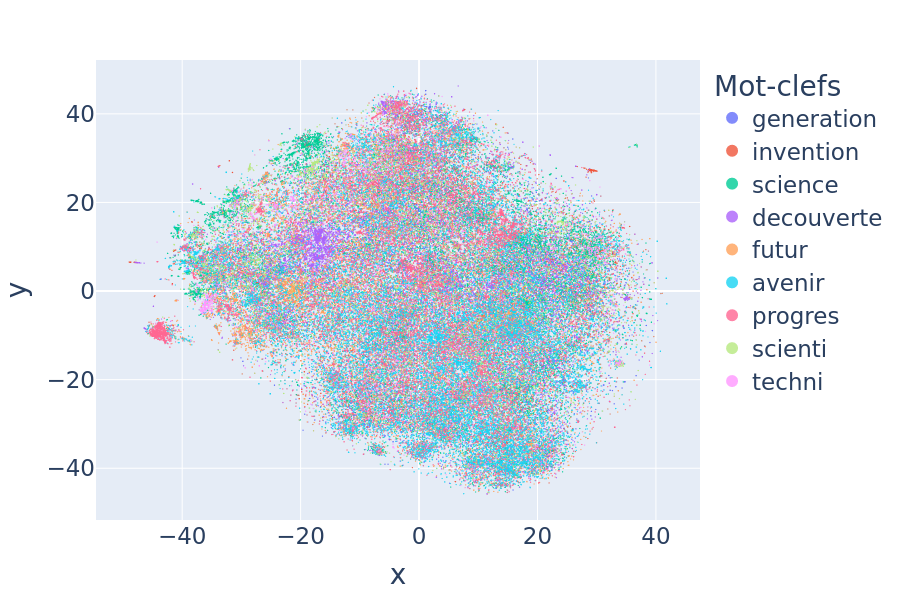

In [107]:
img = px.scatter(contextAvg,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [108]:
'''clustering = DBSCAN(eps= 0.4,metric ='euclidean').fit(np.array(kwsDf[['TSNEx','TSNEy']].apply(tuple, axis=1).tolist()))
kwsDf['cluster'] = clustering.labels_
kwsDf['cluster'] = kwsDf['cluster'].apply(str)
topLabel = kwsDf['cluster'].value_counts().index[:10]
#kwsDf['cluster'].value_counts()'''

"clustering = DBSCAN(eps= 0.4,metric ='euclidean').fit(np.array(kwsDf[['TSNEx','TSNEy']].apply(tuple, axis=1).tolist()))\nkwsDf['cluster'] = clustering.labels_\nkwsDf['cluster'] = kwsDf['cluster'].apply(str)\ntopLabel = kwsDf['cluster'].value_counts().index[:10]\n#kwsDf['cluster'].value_counts()"

In [109]:
'''kwsDf['cluster'] = kwsDf['cluster'].apply(lambda x : x if x in topLabel else topLabel[0]).apply(str)
img = px.scatter(kwsDf,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'cluster')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    font_size = 23,
    legend= {'itemsizing': 'constant'}
    legend_title="Cluster",
)
Image(img.to_image(format="png", width=900, height=500))'''

'kwsDf[\'cluster\'] = kwsDf[\'cluster\'].apply(lambda x : x if x in topLabel else topLabel[0]).apply(str)\nimg = px.scatter(kwsDf,\n                   x = \'TSNEx\',\n                   y = \'TSNEy\',\n                   color = \'cluster\')\n                   #mode = \'markers\',\n                   #marker = {\'size\': 2},\n                   #hoverinfo=\'skip\')\nimg.update_traces(marker={\'size\': 1.5,\'opacity\' :0.8})\nimg.update_layout(\n    #title="Plot Title",\n    font_size = 23,\n    legend= {\'itemsizing\': \'constant\'}\n    legend_title="Cluster",\n)\nImage(img.to_image(format="png", width=900, height=500))'

In [189]:
img = px.scatter(contextAvg.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 8,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



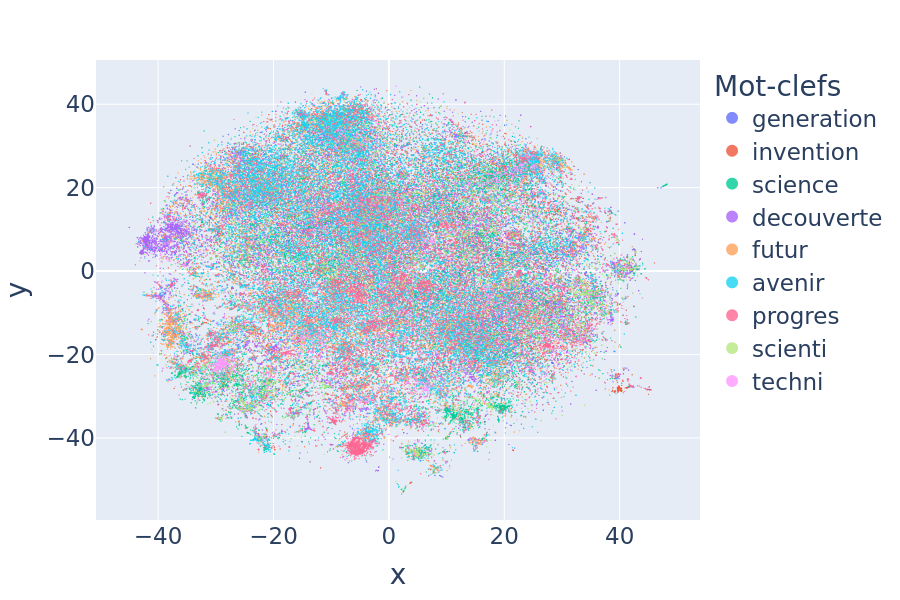

In [118]:
# idf weight
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
contextAvgIDF = pd.DataFrame(textDf.apply(lambda row : wsd.getContextAvg(row, sub=True, window=20, weight= 'idf'), axis=1).explode().tolist(),
                             columns = ['ID','kw','word','nWord','vector','context'])
contextAvgIDF = contextAvgIDF[(contextAvgIDF.nWord>5) & (contextAvgIDF.context.apply(len)>25)]
contextAvgIDF['TSNEx'],contextAvgIDF['TSNEy'] = zip(*TSNE(n_components = 2, 
                                                     perplexity = 100,
                                                     init = 'pca',
                                                     early_exaggeration = 30,
                                                     metric='cosine', 
                                                     learning_rate = 'auto', 
                                                     n_iter_without_progress = 200,
                                                     square_distances=True,
                                                     n_iter = 1000).fit_transform(np.array(contextAvgIDF.vector.tolist()))[:,:2])
img = px.scatter(contextAvgIDF,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [211]:

img = px.scatter(contextAvgIDF.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 8,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

### Predict from average Word2Vec Skip-Gram, Window = 12, topn = 5

In [214]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvg = pd.DataFrame(textDf.apply(wsd.getPredictedAvg,axis=1).explode().tolist(),
                            columns = ['ID','kw','word','nWord','vector','context'])
predictedAvg = predictedAvg.dropna()[(predictedAvg.nWord>5) & (predictedAvg.context.apply(len)>25)]

In [215]:
(predictedAvg['TSNEx'],
 predictedAvg['TSNEy']) = zip(*TSNE(n_components = 2, 
                               perplexity = 100,
                               init = 'pca',
                               early_exaggeration = 30,
                               metric='euclidean', 
                               learning_rate = 'auto', 
                               n_iter_without_progress = 200,
                               square_distances=True,
                               n_iter = 1000).fit_transform(np.array(predictedAvg.vector.tolist()))[:,:2])

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



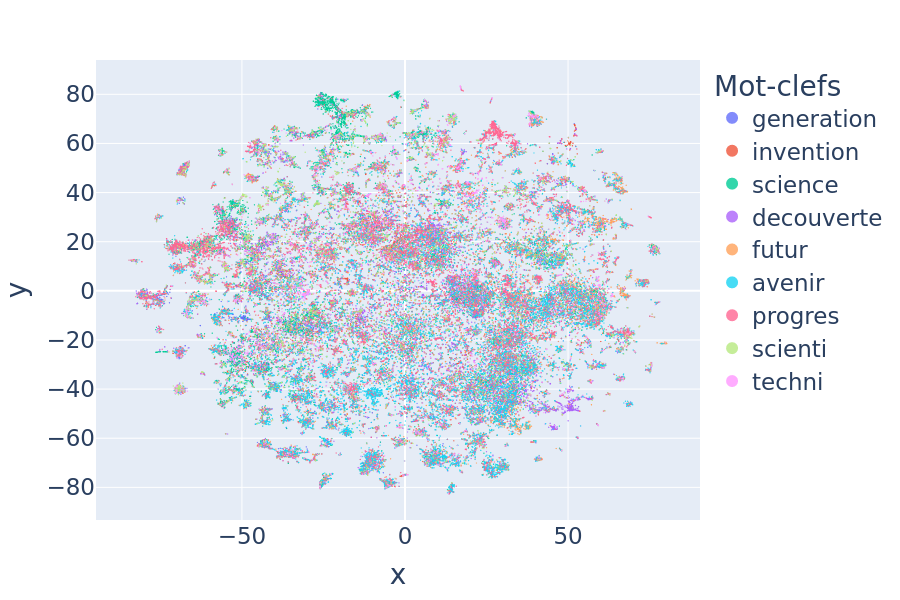

In [216]:
img = px.scatter(predictedAvg,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [220]:
img = px.scatter(predictedAvg.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

### Predict from average Word2Vec Skip-Gram, Window = 12, topn = 20

In [124]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvgWin20 = pd.DataFrame(textDf.apply(lambda row : wsd.getPredictedAvg(row,20), axis=1).explode().tolist(),
                            columns = ['ID','kw','word','nWord','vector','context'])
predictedAvgWin20 = predictedAvgWin20.dropna()[(predictedAvgWin20.nWord>5) & (predictedAvgWin20.context.apply(len)>25)]


In [125]:
(predictedAvgWin20['TSNEx'],
 predictedAvgWin20['TSNEy']) = zip(*TSNE(n_components = 2, 
                               perplexity = 100,
                               init = 'pca',
                               early_exaggeration = 30,
                               metric='euclidean', 
                               learning_rate = 'auto', 
                               n_iter_without_progress = 200,
                               square_distances=True,
                               n_iter = 1000).fit_transform(np.array(predictedAvgWin20.vector.tolist()))[:,:2])

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



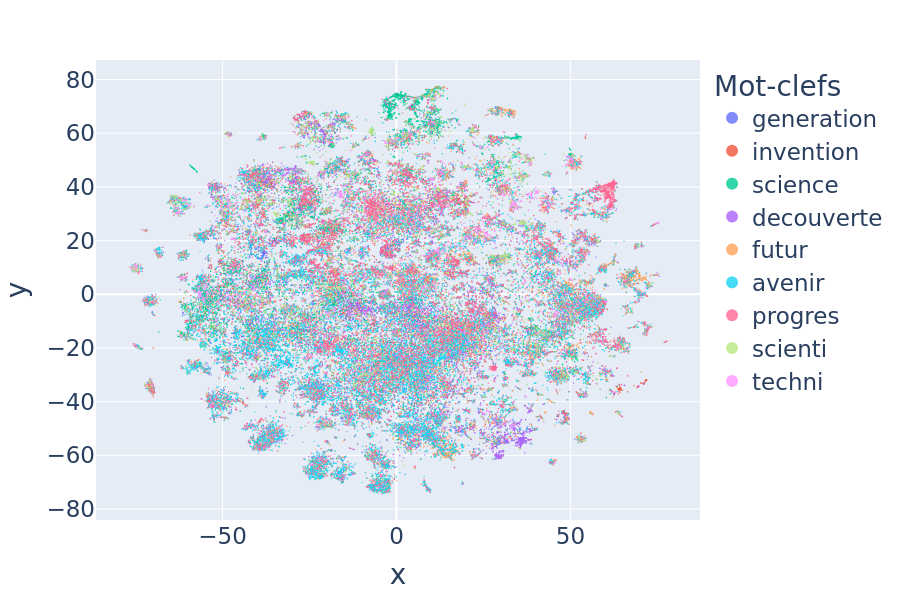

In [126]:
img = px.scatter(predictedAvgWin20,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [188]:
img = px.scatter(predictedAvgWin20.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)

img

## Predict from average Word2Vec, skip gram, window = 20, topn = 5

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



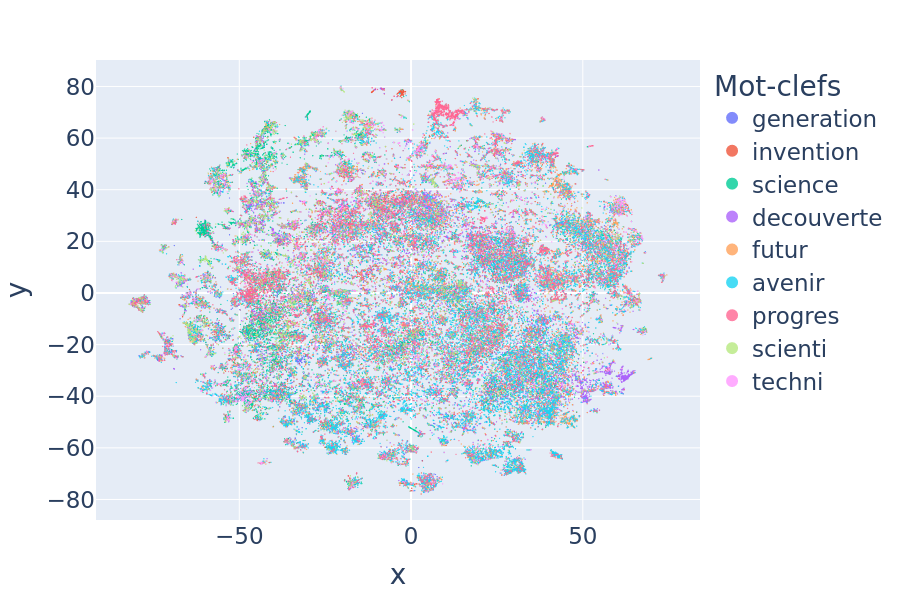

In [218]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvgWin20Top5 = pd.DataFrame(textDf.apply(lambda row : wsd.getPredictedAvg(row,window=20,topn=5), axis=1).explode().tolist(),
                            columns = ['ID','kw','word','nWord','vector','context'])
predictedAvgWin20Top5 = predictedAvgWin20Top5.dropna()[(predictedAvgWin20Top5.nWord>5) & (predictedAvgWin20Top5.context.apply(len)>25)]

(predictedAvgWin20Top5['TSNEx'],
 predictedAvgWin20Top5['TSNEy']) = zip(*TSNE(n_components = 2, 
                               perplexity = 100,
                               init = 'pca',
                               early_exaggeration = 30,
                               metric='euclidean', 
                               learning_rate = 'auto', 
                               n_iter_without_progress = 200,
                               square_distances=True,
                               n_iter = 1000).fit_transform(np.array(predictedAvgWin20Top5.vector.tolist()))[:,:2])
img = px.scatter(predictedAvgWin20Top5,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

## Predict from average Word2Vec, skip gram, window = 12, topn = 20, include kw

/tmp/ipykernel_890146/645062443.py:40: RuntimeWarning:

invalid value encountered in double_scalars

/tmp/ipykernel_890146/2046918854.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


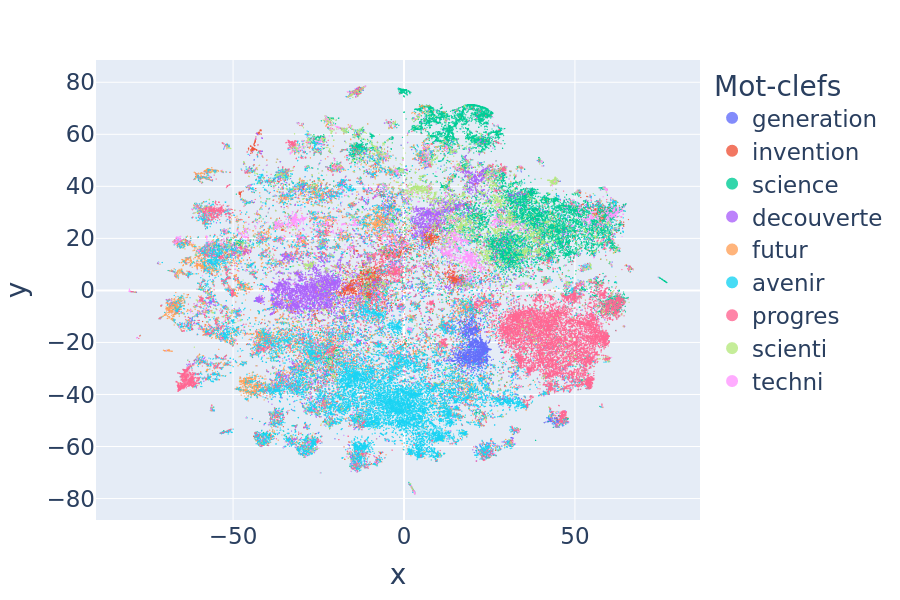

In [255]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvgWin20Top5I = pd.DataFrame(textDf.apply(lambda row : wsd.getPredictedAvg(row,window=12,topn=20,includeKW=True), axis=1).explode().tolist(),
                            columns = ['ID','kw','word','nWord','vector','context'])
predictedAvgWin20Top5I = predictedAvgWin20Top5I.dropna()[(predictedAvgWin20Top5I.nWord>5) & 
                                                         (predictedAvgWin20Top5I.context.apply(len)>25)&
                                                         (predictedAvgWin20Top5I.vector.apply(lambda x : sum(x.shape))>1)]

(predictedAvgWin20Top5I['TSNEx'],
 predictedAvgWin20Top5I['TSNEy']) = zip(*TSNE(n_components = 2, 
                               perplexity = 100,
                               init = 'pca',
                               early_exaggeration = 30,
                               metric='euclidean', 
                               learning_rate = 'auto', 
                               n_iter_without_progress = 200,
                               square_distances=True,
                               n_iter = 1000).fit_transform(np.array(predictedAvgWin20Top5I.vector.tolist()))[:,:2])
img = px.scatter(predictedAvgWin20Top5I,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [257]:
img = px.scatter(predictedAvgWin20Top5I.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)

img

## Predict from average Word2Vec, skip gram, window = 20, topn = 20, include kw

/tmp/ipykernel_890146/645062443.py:40: RuntimeWarning:

invalid value encountered in double_scalars

/tmp/ipykernel_890146/3883758918.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



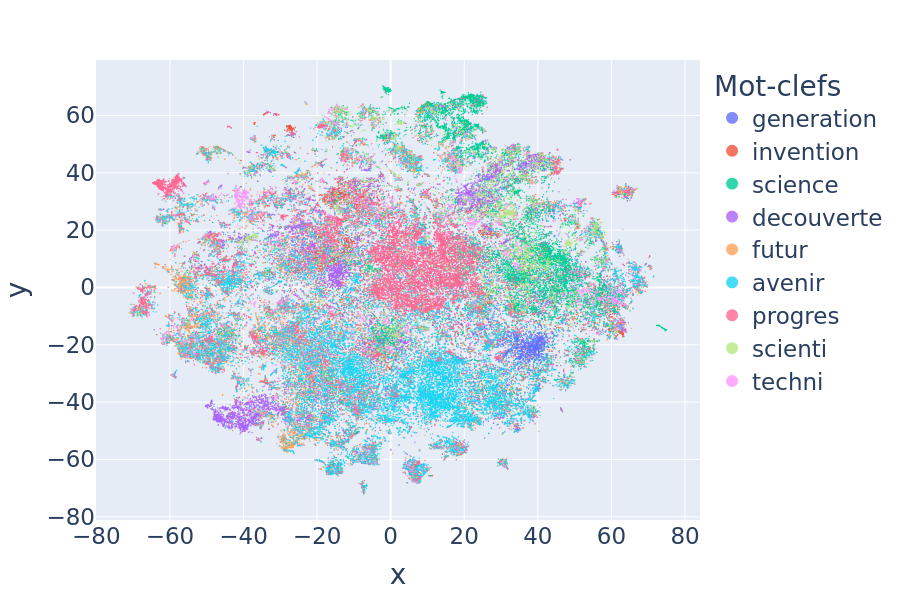

In [258]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvgWin20Top20I = pd.DataFrame(textDf.apply(lambda row : wsd.getPredictedAvg(row,window=20,topn=20,includeKW=True), axis=1).explode().tolist(),
                            columns = ['ID','kw','word','nWord','vector','context'])
predictedAvgWin20Top20I = predictedAvgWin20Top20I.dropna()[(predictedAvgWin20Top20I.nWord>5) & 
                                                         (predictedAvgWin20Top20I.context.apply(len)>25)&
                                                         (predictedAvgWin20Top20I.vector.apply(lambda x : sum(x.shape))>1)]

(predictedAvgWin20Top20I['TSNEx'],
 predictedAvgWin20Top20I['TSNEy']) = zip(*TSNE(n_components = 2, 
                               perplexity = 100,
                               init = 'pca',
                               early_exaggeration = 30,
                               metric='euclidean', 
                               learning_rate = 'auto', 
                               n_iter_without_progress = 200,
                               square_distances=True,
                               n_iter = 1000).fit_transform(np.array(predictedAvgWin20Top20I.vector.tolist()))[:,:2])
img = px.scatter(predictedAvgWin20Top20I,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [261]:
img = px.scatter(predictedAvgWin20Top20I.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)

img

### Context Average Word2Vec CBOW, Window = 12

In [128]:
wsdCBOW = W2VWSD(Word2Vec.load("models/embeddings/Word2Vec_WSD_CBOW.model") ,keywords)
wsdCBOW.idf = idf

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



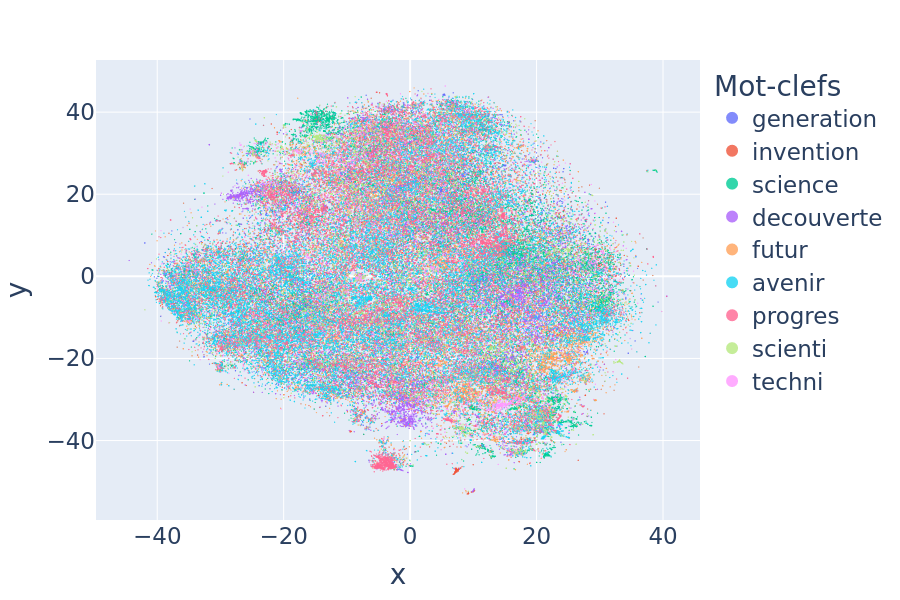

In [129]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
contextAvgCBOW = pd.DataFrame(textDf.apply(wsd.getContextAvg,axis=1).explode().tolist(),
                          columns = ['ID','kw','word','nWord','vector','context'])
contextAvgCBOW = contextAvgCBOW[(contextAvgCBOW.context.apply(len)>25)&(contextAvgCBOW.nWord>5)]
contextAvgCBOW['TSNEx'],contextAvgCBOW['TSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='euclidean', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(contextAvgCBOW.vector.tolist()))[:,:2])
img = px.scatter(contextAvgCBOW,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [ ]:
contextAvgCBOW['cTSNEx'],contextAvgCBOW['cTSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='cosine', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(contextAvgCBOW.vector.tolist()))[:,:2])
img = px.scatter(contextAvgCBOW,
                   x = 'cTSNEx',
                   y = 'cTSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [ ]:
img = px.scatter(contextAvgCBOW.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

## predict from Average Word2Vec CBOW, Window = 12

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



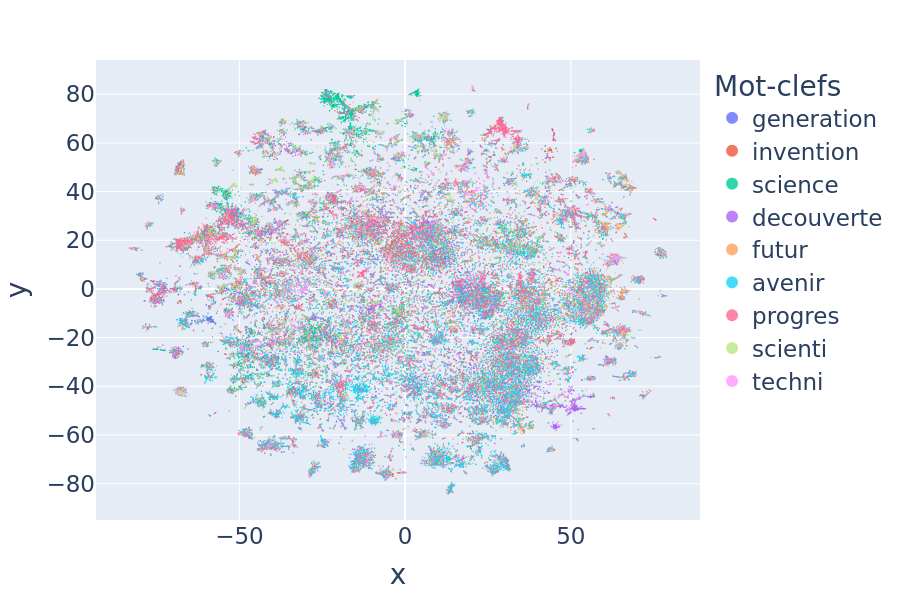

In [133]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvgCBOW = pd.DataFrame(textDf.apply(wsd.getPredictedAvg,axis=1).explode().tolist(),
                          columns = ['ID','kw','word','nWord','vector','context'])
predictedAvgCBOW = predictedAvgCBOW[predictedAvgCBOW.context.apply(len)>25&(predictedAvgCBOW.nWord>5)]
predictedAvgCBOW['TSNEx'],predictedAvgCBOW['TSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='euclidean', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(predictedAvgCBOW.vector.tolist()))[:,:2])
img = px.scatter(predictedAvgCBOW,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [217]:
img = px.scatter(predictedAvgCBOW.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw',
                   hover_data = ['word','context']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

## predict from Average Word2Vec CBOW, Window = 20, topn=20, including KW

In [262]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
predictedAvgCBOWwin20top20I = pd.DataFrame(textDf.apply(lambda row : wsd.getPredictedAvg(row,window=20,topn=20,includeKW=True),axis=1).explode().tolist(),
                          columns = ['ID','kw','word','nWord','vector','context'])
predictedAvgCBOWwin20top20I = predictedAvgCBOWwin20top20I[predictedAvgCBOWwin20top20I.context.apply(len)>25&(predictedAvgCBOWwin20top20I.nWord>5)]
predictedAvgCBOWwin20top20I['TSNEx'],predictedAvgCBOWwin20top20I['TSNEy'] = zip(*TSNE(n_components = 2, 
                                          perplexity = 100,
                                          init = 'pca',
                                          early_exaggeration = 30,
                                          metric='euclidean', 
                                          learning_rate = 'auto', 
                                          n_iter_without_progress = 200,
                                          square_distances=True,
                                          n_iter = 1000).fit_transform(np.array(predictedAvgCBOWwin20top20I.vector.tolist()))[:,:2])
img = px.scatter(predictedAvgCBOWwin20top20I,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

/tmp/ipykernel_890146/645062443.py:40: RuntimeWarning:

invalid value encountered in double_scalars

/tmp/ipykernel_890146/1740934388.py:13: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: setting an array element with a sequence.

## WSD with BERT contextual embeddings

In [135]:
class BERTWSD:
    def __init__(self, tokenizer,tokEmbs, keywords):
        self.tokenizer = tokenizer
        self.keywords = keywords
        self.decodedKWs = [unidecode(kw) for kw in keywords]
        self.tokEmbs = tokEmbs
        
        
    def getSubListIndex(self, subl,l):
        results=[]
        subll=len(subl)
        index = [(ind,ind+subll) 
                 for ind in (i for i,e in enumerate(l) if e==subl[0]) 
                 if l[ind:ind+subll]==subl]
        return index

    
    def getKwsTokens(self,content):
        contentDecoded = unidecode(content).lower().split()
        content = content.split()
        kws = [(content[ind], kw) 
                for ind, word in enumerate(contentDecoded) 
                for kw in self.decodedKWs
                if kw in word]
        inds = [(tokenizer.encode(word, add_special_tokens=False), fullWord, kw)
                for fullWord, kw in kws
                for word in re.split('[^\p{l}]',fullWord)
                if kw in unidecode(word)]
        
        return inds
    
    
    def getEmbeddings(self, row):
        kwTokens = row['kwsTokens']
        embs = []
        for kwToken in kwTokens:
            kwID = kwToken[0]
            kwIndex = self.getSubListIndex(kwID, row['tokens'])
            for rng in kwIndex:
                tokEmb = sum(self.tokEmbs[(row['ID'],str(i))] for i in range(*rng))
                embs.append((kwToken[1],kwToken[2],tokEmb))
        return embs
   

In [136]:
with open(f'data/bertEmbeddings/tokEmbs.npz', 'rb') as tokFile:
    zipedFiles = np.load(tokFile)
    embs = [zipedFiles[file][:len(zipedFiles[file])]
            for file in zipedFiles if 'embs' in file]
    index = [zipedFiles[file][:len(zipedFiles[file])]
            for file in zipedFiles if 'index' in file]
    tokEmbs = pd.DataFrame(np.vstack(embs),index =np.concatenate(index)).apply(np.array,axis=1)
    del embs
    del index
    gc.collect()

In [137]:
BERTDfKws = pd.read_pickle('data/le_figaro_BERT_filtered.gz')

In [138]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-french-europeana-cased")

In [139]:
bertwsd = BERTWSD(tokenizer, tokEmbs, keywords)

In [140]:
BERTDfKws['kwsTokens'] = BERTDfKws.content.apply(bertwsd.getKwsTokens)
BERTDfKws['kwEmb'] = BERTDfKws.apply(bertwsd.getEmbeddings, axis=1)
BERTDfKws = BERTDfKws.drop(columns='kwsTokens').explode( 'kwEmb')
BERTDfKws = BERTDfKws[~BERTDfKws['kwEmb'].isna()].copy()
(BERTDfKws['word'],
 BERTDfKws['keyword'],
 BERTDfKws['kwEmb']) = zip(*BERTDfKws['kwEmb'])

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



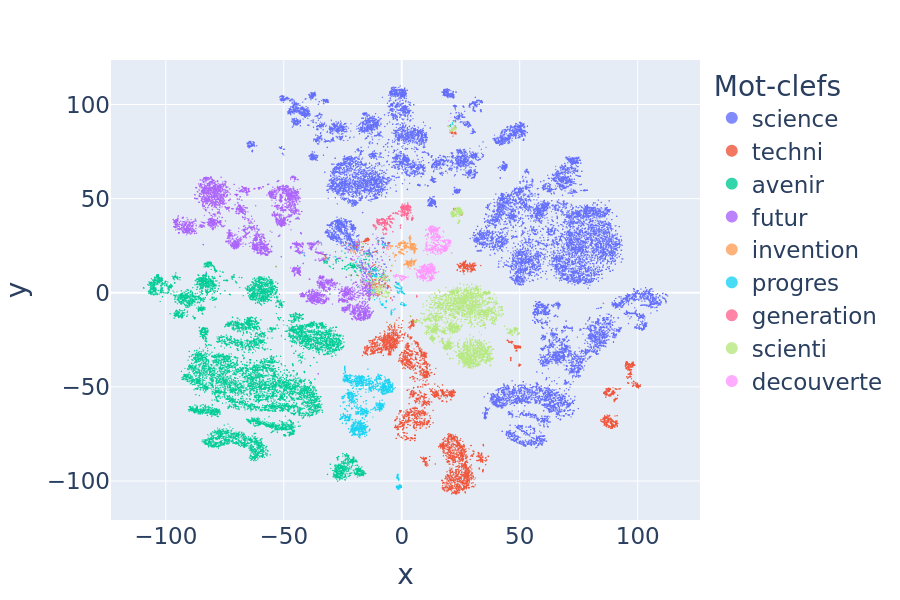

In [152]:
BERTSample = BERTDfKws[['ID','kwEmb','keyword','word','content']].sample(frac=0.5)
contentToPrint = lambda row: '<br>'.join(re.findall('.{,30}'+row['word'] + '.{,30}', row['content']))
BERTSample['content'] = BERTSample.apply(contentToPrint, axis = 1)
BERTSample['TSNEx'],BERTSample['TSNEy'] = zip(*TSNE(n_components = 2, 
                                                     perplexity = 50,
                                                     init = 'pca',
                                                     early_exaggeration = 10,
                                                     metric='cosine', 
                                                     learning_rate = 'auto', 
                                                     n_iter_without_progress = 200,
                                                     square_distances=True,
                                                     n_iter = 1000).fit_transform(np.array(BERTSample.kwEmb.tolist()))[:,:2])
img = px.scatter(BERTSample,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'keyword')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [153]:
img = px.scatter(BERTSample.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'keyword',
                   hover_data = ['word','content']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

## Doc Embeddings

In [143]:
with open(f'data/bertEmbeddings/docEmbs.npz', 'rb') as tokFile:
    zipedFiles = np.load(tokFile)
    embs = [zipedFiles[file][:len(zipedFiles[file])]
            for file in zipedFiles if 'embs' in file]
    index = [zipedFiles[file][:len(zipedFiles[file])]
            for file in zipedFiles if 'index' in file]
    docEmbs = pd.DataFrame(np.vstack(embs),index =np.concatenate(index)).apply(np.array,axis=1)
    del embs
    del index

In [144]:
BERTDfKws['docEmb'] = BERTDfKws.ID.apply(docEmbs.get)

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


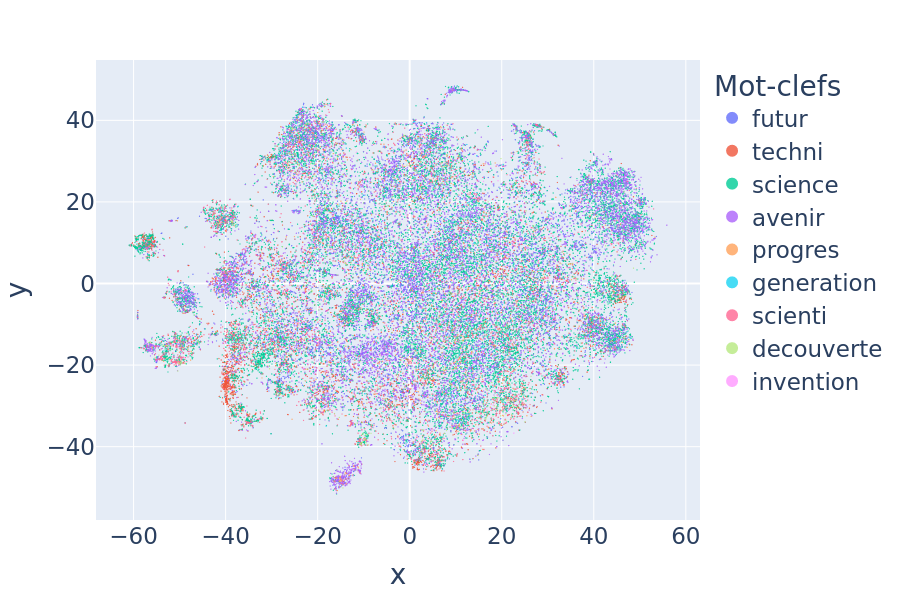

In [147]:
BERTDoc = BERTDfKws.drop_duplicates('ID')[['ID','docEmb','keyword','word','content']].sample(frac=0.5)
contentToPrint = lambda content: '<br>'.join([' '.join(content[i:(i+10)]) for i in range(0,len(content),10)])
BERTDoc['content'] = BERTDoc.content.str.split().apply(contentToPrint)
BERTDoc['TSNEx'],BERTDoc['TSNEy'] = zip(*TSNE(n_components = 2, 
                                                     perplexity = 100,
                                                     init = 'pca',
                                                     early_exaggeration = 25,
                                                     metric='cosine', 
                                                     learning_rate = 'auto', 
                                                     n_iter_without_progress = 200,
                                                     square_distances=True,
                                                     n_iter = 1000).fit_transform(np.array(BERTDoc.docEmb.tolist()))[:,:2])
img = px.scatter(BERTDoc,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'keyword')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [ ]:
res = umap.UMAP().fit_transform(np.array(BERTDoc.docEmb.tolist()))[:,:2]
BERTDoc['UMAPx'],BERTDoc['UMAPy'] = zip(*res)

In [ ]:
img = px.scatter(BERTDoc,
                   x = 'UMAPx',
                   y = 'UMAPy',
                   color = 'keyword')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [ ]:
img = px.scatter(BERTDoc.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'keyword',
                   hover_data = ['word','content']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



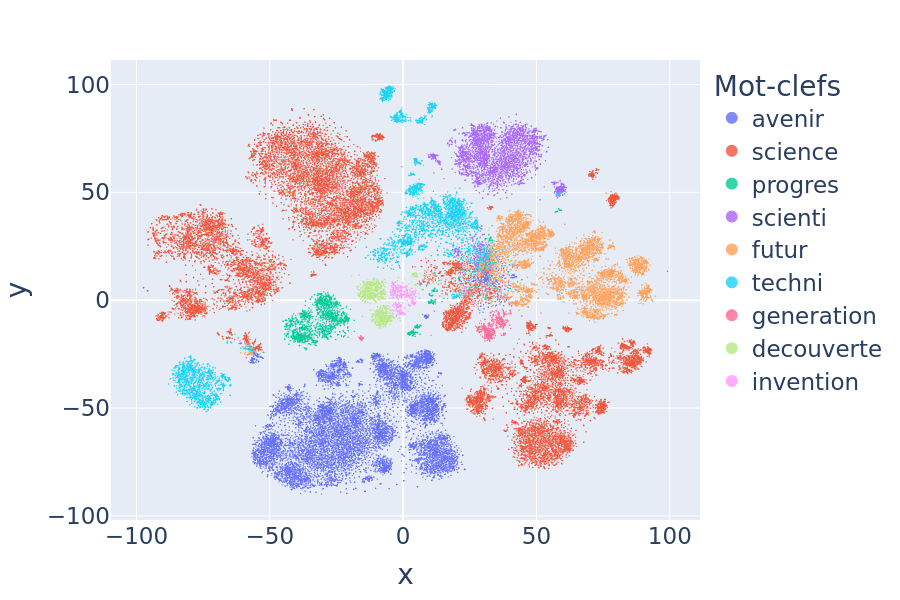

In [150]:
BERTDfKws['mixedEmbs'] = list(np.array(BERTDfKws.docEmb.tolist(),dtype='float32') * 
                          np.array(BERTDfKws.kwEmb.tolist(),dtype='float32'))
BERTMixed = BERTDfKws[['ID','mixedEmbs','keyword','word','content']].sample(frac=0.5)
contentToPrint = lambda row: '<br>'.join(re.findall('.{,40}'+row['word'] + '.{,40}', row['content']))
BERTMixed['content'] = BERTMixed.apply(contentToPrint, axis = 1)
BERTMixed['TSNEx'],BERTMixed['TSNEy'] = zip(*TSNE(n_components = 2, 
                                                     perplexity = 50,
                                                     init = 'pca',
                                                     early_exaggeration = 10,
                                                     metric='cosine', 
                                                     learning_rate = 'auto', 
                                                     n_iter_without_progress = 200,
                                                     square_distances=True,
                                                     n_iter = 1000).fit_transform(np.array(BERTMixed.mixedEmbs.tolist()))[:,:2])
img = px.scatter(BERTMixed,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'keyword')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
Image(img.to_image(format="png", width=900, height=600))

In [151]:
img = px.scatter(BERTMixed.sample(2000),
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'keyword',
                   hover_data = ['word','content']
                   )
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="x",
    yaxis_title="y",
    font_size = 23,
    legend= {'itemsizing': 'constant'},
    legend_title="Mot-clefs",
)
#Image(img.to_image(format="png", width=900, height=500))
img

In [117]:
gc.collect()

0

In [127]:
BERTDfKws.content.apply(lambda t : 'neveu' in t).sum()

678